# Dev for perilune targeting functions

In [4]:
using LinearAlgebra
using Roots
using Plots
using DifferentialEquations
using Dierckx
using Suppressor: @suppress_err
using ProgressMeter

using AstrodynamicsBase

In [42]:
plotly()

┌ Warning: For saving to png with the `Plotly` backend `PlotlyBase` and `PlotlyKaleido` need to be installed.
│   err = expected package `DataFrames [a93c6f00]` to exist in the manifest (use `resolve` to populate the manifest)
└ @ Plots C:\Users\yshimane3\.julia\packages\Plots\io9zQ\src\backends.jl:552


Plots.PlotlyBackend()

In [5]:
include("../R3BP/src/R3BP.jl")

Main.R3BP

In [6]:
paramsBCR4BP = R3BP.get_bcr4bp_param("399", "301")

a_m1_sun: 1.496e8, gm_sun: 1.3271244004193938e11
ω_s: -0.9253018261815922


Main.R3BP.BCR4BP_param(0.012150584269940354, 384400.0, 375190.2619517228, 403503.2355022598, 66182.92311059945, 328900.5598102475, 389.1779396462019, -0.9253018261815922, 2.547698355919253e6)

In [7]:
params = R3BP.get_cr3bp_param(399, 301)
mu = params.mu

0.012150584269940354

In [8]:
# create manifold of some halo
X0 = [1.1203613844775193, 0.0, 0.0018553374006845221, 0.0, 0.176112664775856, 0.0]
#[1.176924090973164, 0.0, -0.060210863312217, 0.0, -0.173836346247689, 0.0];
T = 3.415477359772662  #3.385326412831325;

In [9]:
tspan = (0.0, T)
p = (mu)
prob = ODEProblem(R3BP.rhs_cr3bp_sv!, X0, tspan, p, method=Tsit5(), reltol=1e-12, abstol=1e-12)
sol = solve(prob);

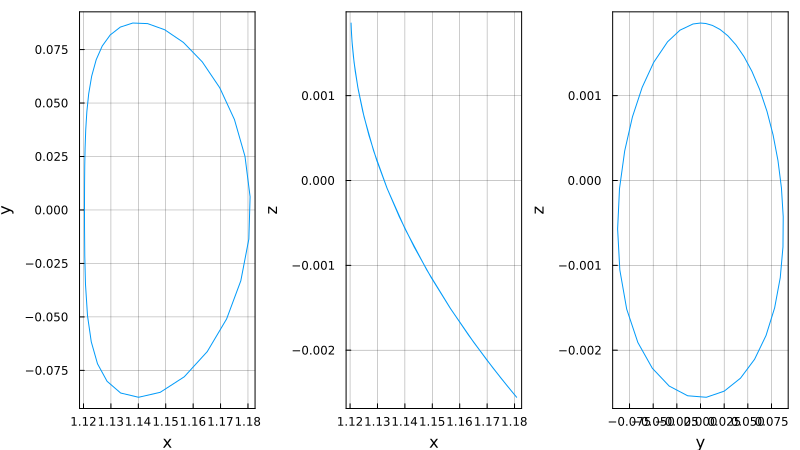

In [10]:
solarr = R3BP.sol_to_arrays(sol)   # get state-history from sol for plotting
p1 = plot(solarr[1,:], solarr[2,:], xlabel="x", ylabel="y", label=false, gridalpha=0.4)
p2 = plot(solarr[1,:], solarr[3,:], xlabel="x", ylabel="z", label=false, gridalpha=0.4)
p3 = plot(solarr[2,:], solarr[3,:], xlabel="y", ylabel="z", label=false, gridalpha=0.4)
plot(p1,p2,p3, layout = (1,3), size=(800, 450), frame_style=:box)

In [63]:
r2_threshold = 0.8
function condition(u,t,integrator)
    r2 = sqrt((u[1]-(1-mu))^2 + u[2]^2 + u[3]^2)
    return r2 - r2_threshold
    #return u[2] - 0.8
end
affect!(integrator) = terminate!(integrator)
cb = ContinuousCallback(condition,affect!);

In [64]:
# parameters for manifolds
stability = true;
tf = -20.0
N = 50
direction = "positive"

# generate manifolds
sim = R3BP.get_manifold(
    mu, X0, T, tf, stability, N, direction, cb);

In [65]:
sum([sol.retcode == :Terminated for sol in sim]) == length(sim)

true

In [66]:
plot_manif = plot(;linealpha=0.4, vars=(1,2), flip=false, aspect_ratio=:equal, size=(800,650),
     frame_style=:box, gridalpha=0.4, xlabel="x", ylabel="y")
for sol in sim
    plot!(plot_manif, Array(sol)[1,:], Array(sol)[2,:], label=false,
      linealpha=0.4, vars=(1,2), flip=false, c=:dodgerblue)
end
plot_manif

## LLO targeting

In [67]:
ps = hcat([sol.u[end] for sol in sim]...)

6×50 Matrix{Float64}:
  1.5018       1.53375      1.55778     …   1.41757      1.46228
  0.613052     0.58479      0.561397        0.67478      0.644128
 -0.00423157  -0.004016    -0.00359951     -0.00375412  -0.0041639
 -0.0234572   -0.0676437   -0.107339        0.060293     0.0211391
 -0.847681    -0.87374     -0.89083        -0.767568    -0.81173
  0.00137794   0.00187595   0.00220946  …  -3.66161e-5   0.000724421

In [68]:
plot_list = []
i_strip = 2
for i = 1:6
    index = LinRange(1,size(ps,2),size(ps,2))
    push!(plot_list, scatter(ps[i_strip, :], ps[i, :], zcolor=index))
end
plot(plot_list...; frame_style=:box, layout=(2,3), size=(700,500))

In [95]:
# process for top and bottom interpolation
function separate_top_bottom(xs, ys)
    n = size(xs,1)
    direction = 0
    flipped = Int[]
    for i = 1:n-1
        if direction * sign(xs[i+1] - xs[i]) < 0
            push!(flipped, i)
        end
        direction = sign(xs[i+1] - xs[i])  # update
    end
    if length(flipped)==1
        side1 = hcat(xs[1:flipped[1]], ys[1:flipped[1]])
        side2 = hcat(xs[flipped[1]+1:end], ys[flipped[1]+1:end])

    elseif length(flipped)==2
        side1 = hcat(
            vcat(xs[flipped[2]+1:end], xs[1:flipped[1]])[:],
            vcat(ys[flipped[2]+1:end], ys[1:flipped[1]])[:]
        )
        side2 = hcat(xs[flipped[1]+1:flipped[2]], ys[flipped[1]+1:flipped[2]])
    end
    # order them
    side1 = side1[sortperm(side1[:,1]), :]
    side2 = side2[sortperm(side2[:,1]), :]
    return flipped, side1, side2
end

separate_top_bottom (generic function with 1 method)

In [96]:
flipped, side1, side2 = separate_top_bottom(ps[i_strip, :], ps[1, :])

([13, 34], [0.7535064257156401 1.6451555603312351; 0.7557779635271566 1.6426705529181165; … ; 0.9784768899620628 1.1915218319997054; 0.9786898016867613 1.1921062237115028], [0.7527164268567588 1.6457734057911457; 0.753447576234646 1.644492169954578; … ; 0.976046612038031 1.2053530653573303; 0.9779213590746741 1.196656066642811])

In [224]:
n_interval = 20
n_strip = 8

sides_dict = Dict()
strips_per_state = Dict()
anchors = Vector[]

for i = 1:6
    flipped, side1, side2 = separate_top_bottom(ps[i_strip, :], ps[i, :]);

    # construct spline & evaluate
    anchors = LinRange(side1[1,1], side1[end,1], n_interval)
    spl1 = Spline1D(side1[:,1], side1[:,2])
    y1s = evaluate(spl1, anchors)
    
    spl2 = Spline1D(side2[:,1], side2[:,2])
    y2s = evaluate(spl2, anchors)
    
    # store for plotting
    sides_dict[i] = [hcat(anchors, y1s), hcat(anchors, y2s)]
    
    # get strips
    strips = Dict()
    for j = 1:n_strip
        strips[j] = (y2s-y1s) * j/(n_strip+1) + y1s
    end
    strips_per_state[i] = strips
end

strips_list = []
for j = 1:n_strip
    push!(strips_list,
        [
            strips_per_state[1][j],
            strips_per_state[2][j],
            strips_per_state[3][j],
            strips_per_state[4][j],
            strips_per_state[5][j],
            strips_per_state[6][j],
        ]
    )
end

@show length(strips_list);

length(strips_list) = 8


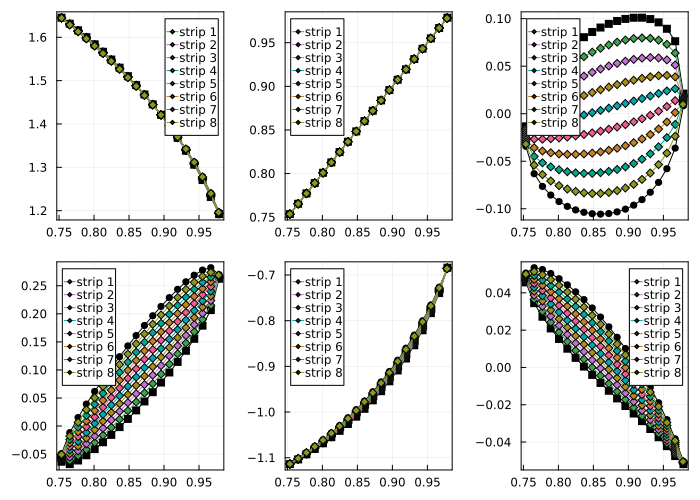

In [324]:
plot_list = []
for i = 1:6
    pps2 = plot(frame_Style=:box)
    plot!(pps2, sides_dict[i][1][:,1], sides_dict[i][1][:,2],
        marker=:square, label=false, color=:black)
    plot!(pps2, sides_dict[i][2][:,1], sides_dict[i][2][:,2],
        marker=:circle, label=false, color=:black)
    push!(plot_list, pps2)
end

for (istrip, strips) in enumerate(strips_list)
    for i = 1:6
        plot!(plot_list[i], strips[i_strip], strips[i], marker=:diamond, label="strip $istrip")
    end
end
plot(plot_list...; frame_style=:box, layout=(2,3), size=(700,500))

In [226]:
r2_threshold_min = 1737/params.lstar
function condition_r2hit(u,t,integrator)
    r2 = sqrt((u[1]-(1-mu))^2 + u[2]^2 + u[3]^2)
    return r2 - r2_threshold_min
end
affect1!(integrator) = terminate!(integrator)
cb1 = ContinuousCallback(condition_r2hit, affect1!);

function condition_apse(u,t,integrator)
    return (u[1]-(1-mu))*u[4] + u[2]*u[5] + u[3]*u[6]
end
affect2! = function (integrator) end
cb2 = ContinuousCallback(condition_apse, affect2!);

cbs = CallbackSet(cb1,cb2);

In [359]:
function find_perilune(sol, mu::Real, get_state::Bool=false)
    r2min = 100.0
    u_min = [1.0,0.0,0.0,0.0,0.0,0.0]
    for u in sol.u
        r2 = sqrt((u[1]-(1-mu))^2 + u[2]^2 + u[3]^2)
        if r2 < r2min
            r2min = r2
            u_min = u
        end
    end
    if get_state == false
        return r2min
    else
        return r2min, u_min
    end
end

find_perilune (generic function with 2 methods)

In [228]:
# propagate each strip forward
tf_fwd = 5.0
prob_base = ODEProblem(R3BP.rhs_cr3bp_sv!, [1,0,0,0,1,0], (0, tf_fwd), [mu,],
    method=Tsit5(), reltol=1e-12, abstol=1e-12, callback=cbs,
)

strip_traj_list = []
perilunes_per_strip = []
@showprogress for strip in strips_list  # length == n_strip
    traj_per_strip = []
    perilunes = Real[]
    for j = 1:n_interval
        _x0 = [
            strip[1][j], strip[2][j], strip[3][j],
            strip[4][j], strip[5][j], strip[6][j],
        ]
        _prob = remake(prob_base; u0=_x0)
        sol = @suppress_err solve(_prob)
        push!(traj_per_strip, sol)
        push!(perilunes, find_perilune(sol, mu))
    end
    
    push!(strip_traj_list, traj_per_strip)
    push!(perilunes_per_strip, perilunes)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


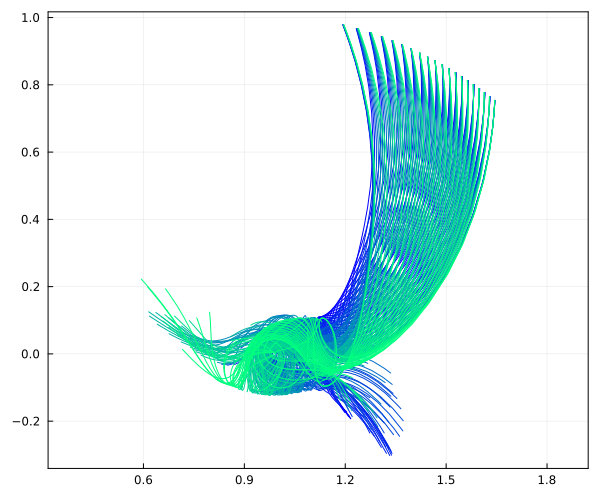

In [229]:
ptraj = plot(frame_style=:box, aspect_ratio=:equal, size=(600,500))

cs = palette(:winter, length(strip_traj_list))
for (ist,traj_per_strip) in enumerate(strip_traj_list)
    for sol in traj_per_strip
        plot!(ptraj, Array(sol)[1,:], Array(sol)[2,:], label=false, color=cs[ist])
    end
end
ptraj

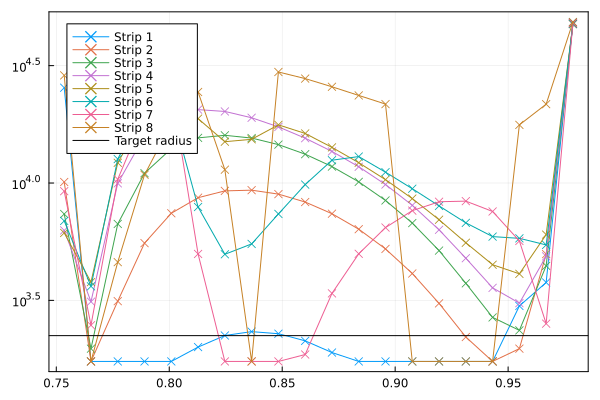

In [230]:
pperi = plot(frame_style=:box, yscale=:log)
for i = 1:n_strip
    plot!(pperi, anchors, perilunes_per_strip[i]*params.lstar,
        marker=:xcross, label="Strip $i")
end
hline!(pperi, [(1737+500)], color=:black, label="Target radius")
pperi

In [323]:
anchors

20-element LinRange{Float64, Int64}:
 0.753506,0.765358,0.77721,0.789062,…,0.943135,0.954986,0.966838,0.97869

### Run interpolation

In [360]:
#for strip in strips_list
function interpolate_strip(
    strip::Vector, perilunes::Vector, target_radius::Real, i_strip::Int
)
    # interpolate along strip
    spl_state = [Spline1D(anchors, strip[i_state]) for i_state=1:6]  # state at manifold
    println([evaluate(spl_state[j], 0.8) for j = 1:6])
    println([evaluate(spl_state[j], 0.85) for j = 1:6])
    
    residual = function (anchor_var, get_state::Bool=false)
        #println("anchor_var: $anchor_var")
        _x0_interp = [evaluate(spl_state[j], anchor_var) for j = 1:6]
        _prob = remake(prob_base; u0=_x0_interp)
        sol_anchor = @suppress_err solve(_prob)
        if get_state == true
            return find_perilune(sol_anchor, mu, get_state)
        else
            return find_perilune(sol_anchor, mu, get_state) - target_radius
        end
    end
    
    # iterate through sampled perilune-going locations
    state_target = Vector[]
    for i = 1:length(perilunes)-1
        if (perilunes[i]-target_radius) * (perilunes[i+1]-target_radius) < 0
            println("\nDetected change in sign at index $i")
            println("anchors[i]   => ", strip[i_strip][i])
            println("anchors[i+1] => ", strip[i_strip][i+1])
            #println("Stored: ", perilunes[i]-target_radius)
            println("Computed: ", residual(strip[i_strip][i]))
            println("Computed: ", residual(strip[i_strip][i+1]))
            res_anchor = find_zero(
                residual, 
                (strip[i_strip][i], strip[i_strip][i+1]),
                Bisection(), atol=1e-8, rtol=1e-8
            )
            # store
            r2min, state_llo = residual(res_anchor, true)
            push!(state_target, state_llo)
            println(r2min - target_radius)
        end
    end
    return state_target
end

interpolate_strip (generic function with 4 methods)

In [362]:
target_radius = (1737+500)/params.lstar
states_llo = interpolate_strip(strips_list[1], perilunes_per_strip[1], target_radius, i_strip);

[1.5846222623247561, 0.8000000000000161, 0.04073650660505071, -0.030571546786327456, -1.0684759920114641, 0.01926211190980644]
[1.5070659260226553, 0.8499999999920663, 0.06535317396191788, 0.02937051639659372, -1.0059677113274599, -0.0006425442435102382]

Detected change in sign at index 1
anchors[i]   => 0.7535064257156401
anchors[i+1] => 0.765358182345699
Computed: 0.060434320211589884
Computed: -0.0013007284079074683
4.9539263351217055e-9

Detected change in sign at index 6
anchors[i]   => 0.812765208865935
anchors[i+1] => 0.824616965495994
Computed: -0.0006175348411986059
Computed: 7.824514386817888e-6
-6.053689536635043e-9

Detected change in sign at index 9
anchors[i]   => 0.8483204787561118
anchors[i+1] => 0.8601722353861713
Computed: 0.00011139025661885838
Computed: -0.0002897170721234089
-4.54505573368319e-9

Detected change in sign at index 17
anchors[i]   => 0.9431345317965837
anchors[i+1] => 0.954986288426643
Computed: -0.0013007284079083106
Computed: 0.001969656831244437
1

In [ ]:
states_llo

In [367]:
# propagate found trajectories backward
tf_fwd = -2.0
prob_base = ODEProblem(R3BP.rhs_cr3bp_sv!, [1,0,0,0,1,0], (0, tf_fwd), [mu,],
    method=Tsit5(), reltol=1e-12, abstol=1e-12, callback=cbs,
)

traj_llo_targeting = []
@showprogress for state in states_llo  # length == n_strip
    _prob = remake(prob_base; u0=state)
    sol = @suppress_err solve(_prob)
    push!(traj_llo_targeting, sol)
end

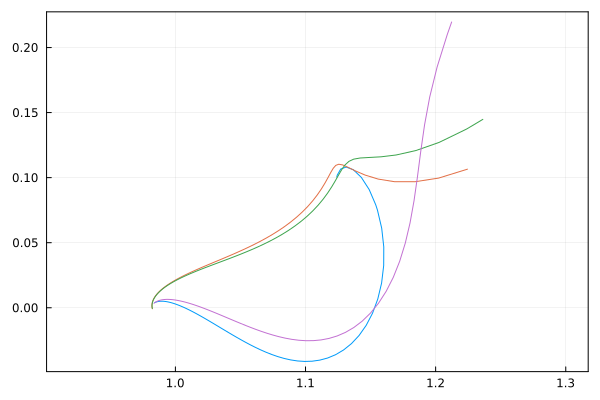

In [368]:
ptraj = plot(frame_style=:box, aspect_ratio=:equal)
for sol in traj_llo_targeting
    plot!(ptraj, Array(sol)[1,:], Array(sol)[2,:], label=false)
end
ptraj